# Visualizing the Parts of the Connectome that Predict Rate of Forgetting

In [1]:
import nilearn.plotting as nip
import nilearn.image as nimg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
oldfont = plt.rcParams['font.sans-serif']
plt.rcParams['font.sans-serif'] = ['FreeSans']

## Load the Power 2011 classification

All of the connectomes in this analysis were extacted from the Power 2011 classification. We will start by first loading the corresponding data table.

In [3]:
power2011 = pd.read_csv("../rsfmri/bin/power_2011.csv")
power2011 = power2011.iloc[:,0:7]
power2011

ROI   X   Y   Z  Network  Color       NetworkName
0      1 -25 -98 -12       -1  White         Uncertain
1      2  27 -97 -13       -1  White         Uncertain
2      3  24  32 -18       -1  White         Uncertain
3      4 -56 -45 -24       -1  White         Uncertain
4      5   8  41 -24       -1  White         Uncertain
..   ...  ..  ..  ..      ...    ...               ...
259  260 -27 -71  37       12  Green  Dorsal attention
260  261 -32  -1  54       12  Green  Dorsal attention
261  262 -42 -60  -9       12  Green  Dorsal attention
262  263 -17 -59  64       12  Green  Dorsal attention
263  264  29  -5  54       12  Green  Dorsal attention

[264 rows x 7 columns]

### Visualize the Brain Parcellation

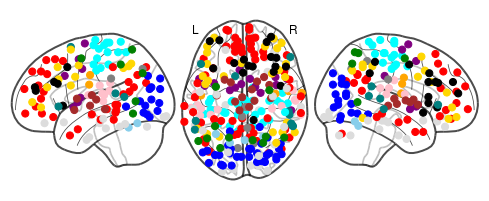

In [4]:
pc = np.zeros((264, 264))
pcol = [x.lower() for x in list(power2011['Color'])]

def colortranslate(x):
    if x.lower() == "yellow":
        return "gold"
    elif x.lower() == "pale blue":
        return "skyblue"
    elif x.lower() == "white":
        return "gainsboro"
    else:
        return x
    
pcol = [colortranslate(x) for x in pcol]
xyz = []
for roi in list(power2011['ROI']):
    entry = power2011.loc[power2011['ROI'] == roi]
    x = int(entry['X'])
    y = int(entry['Y'])
    z = int(entry['Z'])
    xyz.append((x,y,z))
pcoords = np.array(xyz)

img = nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr')

/tmp/ipykernel_276498/917920154.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/power2011.png", figsize=(8, 4), dpi=300)


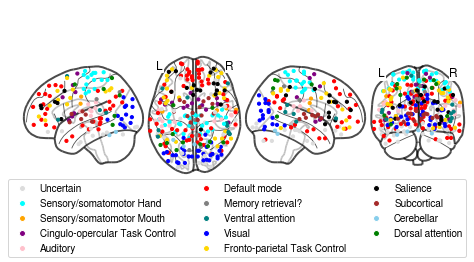

In [5]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,1, figsize=(8,4))
nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzry', axes=axs, node_size=10)

allkols=list(power2011['Color'])
allnets=list(power2011['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=6) for x in [colortranslate(x) for x in kols]]

fig.legend(handles, nets, loc="lower center", ncol=3)
plt.savefig("figures/power2011.png", figsize=(8, 4), dpi=300)
plt.show()

## Visualize the Connectome Matrix

We can visualize the connectome matrix for the 62 participants. First, we load the data:

In [6]:
R = np.zeros((264, 264, 61))
PR = np.zeros((264, 264, 61))

index = 0
for ii in range(1, 63):
    subj = "sub-%03d" % (ii,)
    if ii != 8:
        R[:,:,index]=np.loadtxt("../rsfmri/%s/R_py.txt" % (subj,))
        PR[:,:,index]=np.loadtxt("../rsfmri/%s/PR_py.txt" % (subj,))
        index += 1

Then, we visualize it as a matrix

/tmp/ipykernel_276498/1874652396.py:2: RuntimeWarning: divide by zero encountered in log
  mR = np.tanh(np.mean((np.log(1+R) - np.log(1-R))/2, 2))
/tmp/ipykernel_276498/1874652396.py:3: RuntimeWarning: divide by zero encountered in log
  mPR = np.tanh(np.mean((np.log(1+PR) - np.log(1-PR))/2, 2))


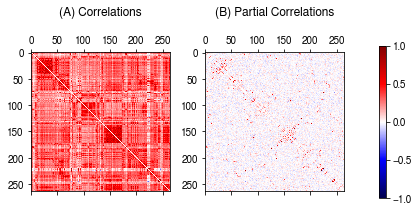

In [7]:
# Calculate mean r values using Fisher's Z transform
mR = np.tanh(np.mean((np.log(1+R) - np.log(1-R))/2, 2))
mPR = np.tanh(np.mean((np.log(1+PR) - np.log(1-PR))/2, 2))


for ii in range(264):
    mR[ii,ii] = 0
    mPR[ii,ii] = 0

fig, axs = plt.subplots(1, 3, figsize=(6, 3), gridspec_kw={'width_ratios': [20, 20, 1]})
im = axs[0].matshow(mR, vmin=-1, vmax=1, cmap="seismic")
axs[0].set_title("(A) Correlations\n")
fig.colorbar(im, cax=axs[2])
axs[1].matshow(mPR, vmin=-0.5, vmax=0.5, cmap="seismic")
axs[1].set_title("(B) Partial Correlations\n")
#axs[2].set_visible(False)
plt.tight_layout()
plt.savefig("figures/connectomes.png", dpi=300)

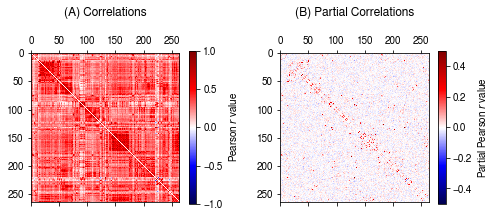

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = axs[0].matshow(mR, vmin=-1, vmax=1, cmap="seismic")
axs[0].set_title("(A) Correlations\n")
cbar = axs[0].figure.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel(r"Pearson $r$ value", rotation=90, va="top")

im = axs[1].matshow(mPR, vmin=-0.5, vmax=0.5, cmap="seismic")
axs[1].set_title("(B) Partial Correlations\n")
cbar = axs[1].figure.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel(r"Partial Pearson $r$ value", rotation=90, va="top")

#axs[2].set_visible(False)
plt.tight_layout()
plt.savefig("figures/connectomes.png", dpi=300)


### Creating a generic function

Here we assemble all of the steps above into a single function.

In [9]:
### Create a Handy Function

def connectome_visualization(variable, name=None, blackbg=True):
    if name is None:
        name = variable
    # Load the data
    data = pd.read_csv("%s.csv" % (variable,))
    
    # Extract Regions
    ROIs = []

    for c in data['connection']:
        roi1, roi2 = c.split("-")

        if int(roi1) not in ROIs:
            ROIs.append(int(roi1))
        if int(roi2) not in ROIs:
            ROIs.append(int(roi2))
    ROIs.sort()

    # Extra ROI data
    sub = power2011[power2011['ROI'].isin( ROIs)]
    N = len(sub['ROI'])
    
    connectome = np.zeros((N, N))
    weighted_connectome = np.zeros((N, N))
    
    for c in range(N):
        for r in range(N):
            roi1 = ROIs[c]
            roi2 = ROIs[r]
            conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
            entry = data.loc[data['connection'] == conn_name]
            if len(entry) == 1:
                beta=float(entry['Beta'])
                connectome[c,r] = beta
                weighted_connectome[c,r] = beta * mPR[int(ROIs[c]-1), int(ROIs[r]-1)]
    
    plt.imshow(connectome)
    plt.title("Connectome (Beta values)")
    plt.show()

    xyz = []
    sub.loc[:,['X', 'Y', 'Z']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        x = int(entry['X'])
        y = int(entry['Y'])
        z = int(entry['Z'])
        xyz.append((x,y,z))
    coords = np.array(xyz)

    colors = []
    sub.loc[:,['Color']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        #col = entry['Color']
        col = entry.iloc[0,5]
        colors.append(col.lower())

    # Replace the stupid "pale blue"
    
    colors = [x if x != "pale blue" else "dodgerblue" for x in colors ]
    nip.plot_connectome(connectome, coords, colorbar=True,
                    title=r"Predictors of %s" % (name,), 
                    black_bg=blackbg, node_color=colors)
    plt.savefig("%s.png" % (variable,))
    nip.show()

    nip.plot_connectome_strength(connectome, coords,
                                 title=r"Importance of ROIs in %s" % (name,))
    plt.savefig("%s_importance.png" % (variable,))
    nip.show()
    
    return connectome, coords, colors, weighted_connectome

## Rate of Forgetting $\alpha$

We use the new function to plot a different variable, the Rate of Forgetting $\alpha$.

Now some prettier visualizations

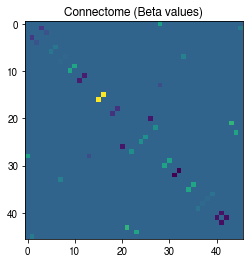

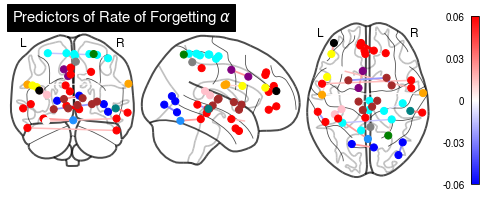

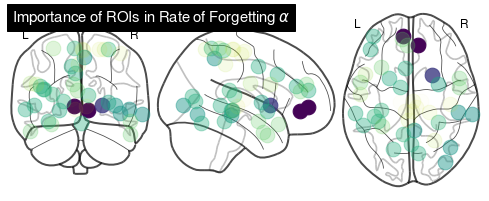

In [10]:
c, nc, cols, wc = connectome_visualization("alpha4", name=r"Rate of Forgetting $\alpha$", blackbg=False)
nip.view_connectome(c, nc, colorbar_fontsize=8)

## Prettier Visualizations
Some prettier visualizations. First, we need to get the network names and colors.

In [11]:
alpha = pd.read_csv("alpha4.csv")
alpha

index network                                      network_names  \
0    7681     1-1  Sensory/somatomotor Hand-Sensory/somatomotor Hand   
1    9268     1-1  Sensory/somatomotor Hand-Sensory/somatomotor Hand   
2   10335     1-1  Sensory/somatomotor Hand-Sensory/somatomotor Hand   
3   11925     2-2  Sensory/somatomotor Mouth-Sensory/somatomotor ...   
4   15363     3-3  Cingulo-opercular Task Control-Cingulo-opercul...   
5   19072     4-4                                  Auditory-Auditory   
6   28883     5-5                          Default mode-Default mode   
7   29405     5-5                          Default mode-Default mode   
8   30209     5-5                          Default mode-Default mode   
9   33920     5-5                          Default mode-Default mode   
10  34438     5-5                          Default mode-Default mode   
11  34707    -1-5                             Uncertain-Default mode   
12  35653     1-6         Sensory/somatomotor Hand-Memory retrieval?   
13  35734     5-6                     Default mode-Memory retrieval?   
14  40009     7-7                                      Visual-Visual   
15  45569     7-7                                      Visual-Visual   
16  46245     2-8  Sensory/somatomotor Mouth-Fronto-parietal Task...   
17  58004     8-9              Fronto-parietal Task Control-Salience   
18  59360   10-10                            Subcortical-Subcortical   
19  59622   10-10                            Subcortical-Subcortical   
20  60683   10-10                            Subcortical-Subcortical   
21  60950   10-10                            Subcortical-Subcortical   
22  62951    5-11                     Default mode-Ventral attention   
23  64806    5-13                            Default mode-Cerebellar   
24  67873    1-12          Sensory/somatomotor Hand-Dorsal attention   

   connection  censor      Beta  
0       25-30    True -0.013796  
1       28-36    True -0.005850  
2       39-40    True  0.006386  
3       45-46    True  0.000550  
4       51-59    True  0.023500  
5       64-73    True -0.021663  
6     107-110    True  0.060395  
7     101-112    True -0.000564  
8     113-115    True -0.015528  
9     128-129    True  0.015907  
10    118-131    True -0.023351  
11    123-132    True  0.015685  
12     13-136    True  0.021903  
13     94-136    True -0.007220  
14    145-152    True  0.022993  
15    161-173    True -0.028745  
16     45-176    True  0.010165  
17    188-220    True  0.024042  
18    224-225    True  0.001759  
19    222-226    True  0.005059  
20    227-230    True -0.024423  
21    230-231    True -0.025399  
22    119-239    True  0.029407  
23    126-246    True  0.023187  
24     25-258    True  0.007565

Then, we define the list of network names and corresponding colors

In [12]:
ROIs = []

FCvals = []
for conn in alpha['connection']:
    roi1, roi2 = conn.split("-")

    if int(roi1) not in ROIs:
        ROIs.append(int(roi1))
    if int(roi2) not in ROIs:
        ROIs.append(int(roi2))
        
    FCvals.append(mPR[int(roi1)-1, int(roi2)-1])
ROIs.sort()

pcol = [colortranslate(x) for x in pcol]

subset = pd.DataFrame(power2011[power2011['ROI'].isin(ROIs)])
print(subset.shape)
subset

(46, 7)


ROI   X   Y   Z  Network      Color                     NetworkName
12    13  -7 -52  61        1       Cyan        Sensory/somatomotor Hand
24    25  29 -39  59        1       Cyan        Sensory/somatomotor Hand
27    28  20 -29  60        1       Cyan        Sensory/somatomotor Hand
29    30 -29 -43  61        1       Cyan        Sensory/somatomotor Hand
35    36  42 -20  55        1       Cyan        Sensory/somatomotor Hand
38    39   2 -28  60        1       Cyan        Sensory/somatomotor Hand
39    40   3 -17  58        1       Cyan        Sensory/somatomotor Hand
44    45 -53 -10  24        2     Orange       Sensory/somatomotor Mouth
45    46  66  -8  25        2     Orange       Sensory/somatomotor Mouth
50    51 -10  -2  42        3     Purple  Cingulo-opercular Task Control
58    59  -5  18  34        3     Purple  Cingulo-opercular Task Control
63    64 -38 -33  17        4       Pink                        Auditory
72    73 -30 -27  12        4       Pink                        Auditory
93    94  -2 -37  44        5        Red                    Default mode
100  101  22  39  39        5        Red                    Default mode
106  107  -7  51  -1        5        Red                    Default mode
109  110   8  42  -5        5        Red                    Default mode
111  112  -2  38  36        5        Red                    Default mode
112  113  -3  42  16        5        Red                    Default mode
114  115  -8  48  23        5        Red                    Default mode
117  118 -58 -30  -4        5        Red                    Default mode
118  119  65 -31  -9        5        Red                    Default mode
122  123  52  -2 -16        5        Red                    Default mode
125  126 -34 -38 -16        5        Red                    Default mode
127  128  52   7 -30        5        Red                    Default mode
128  129 -53   3 -27        5        Red                    Default mode
130  131 -49 -42   1        5        Red                    Default mode
131  132 -31  19 -19       -1      White                       Uncertain
135  136   4 -48  51        6       Gray               Memory retrieval?
144  145   8 -72  11        7       Blue                          Visual
151  152 -18 -68   5        7       Blue                          Visual
160  161  42 -66  -8        7       Blue                          Visual
172  173  37 -81   1        7       Blue                          Visual
175  176 -47  11  23        8     Yellow    Fronto-parietal Task Control
187  188 -42  38  21        8     Yellow    Fronto-parietal Task Control
219  220 -39  51  17        9      Black                        Salience
221  222   6 -24   0       10      Brown                     Subcortical
223  224 -10 -18   7       10      Brown                     Subcortical
224  225  12 -17   8       10      Brown                     Subcortical
225  226  -5 -28  -4       10      Brown                     Subcortical
226  227 -22   7  -5       10      Brown                     Subcortical
229  230  23  10   1       10      Brown                     Subcortical
230  231  29   1   4       10      Brown                     Subcortical
238  239  51 -29  -4       11       Teal               Ventral attention
245  246   1 -62 -18       13  Pale blue                      Cerebellar
257  258  25 -58  60       12      Green                Dorsal attention

Now, we use the `subset` to create the list of network names and corresponding colors

In [13]:
allkols=list(subset['Color'])
allnets=list(subset['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

And now, we visualize that:

/tmp/ipykernel_276498/3440741715.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/alpha4_pretty.png", figsize=(10, 4.2), dpi=300)


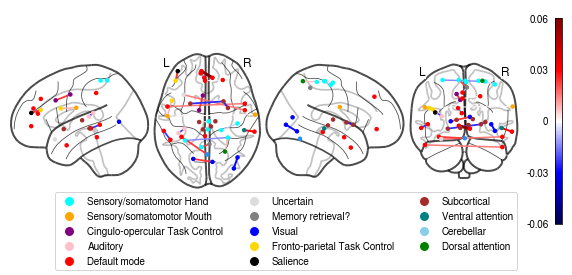

In [14]:
fig, axs = plt.subplots(1,1, figsize=(10, 4.2))

nip.plot_connectome(c, nc, [colortranslate(x) for x in cols], 
                    edge_cmap="seismic", 
                    #edge_cmap="viridis", 
                    axes=axs, node_size=12,
                    display_mode="lzry", colorbar=True, 
                    edge_vmax=0.06, edge_vmin=-0.06)

fig.legend(handles, nets, loc="lower center", ncol=3)
plt.savefig("figures/alpha4_pretty.png", figsize=(10, 4.2), dpi=300)
plt.show()

## Node Importance

AttributeError: module 'nilearn.plotting' has no attribute 'plot_markers'

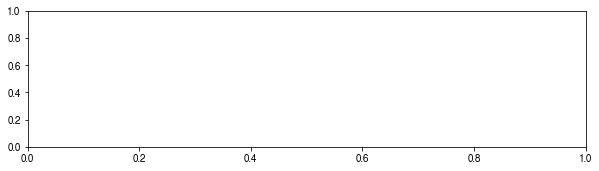

In [15]:
importance = np.sum(np.abs(c), axis=1)
fig, axs = plt.subplots(1,1, figsize=(10, 2.5))
nip.plot_markers(node_values=importance, node_coords=nc, alpha=0.6, 
                 axes=axs, display_mode="lzry", node_cmap="plasma", node_vmin=-0, node_vmax=0.075)
plt.savefig("figures/alpha4_importance.png", dpi=300)
plt.show()

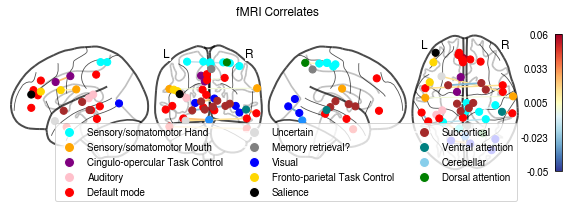

In [16]:
fig, axs = plt.subplots(1,1, figsize=(10, 2.8))

nip.plot_connectome(c, nc, [colortranslate(x) for x in cols], 
                    edge_cmap="RdYlBu_r", axes=axs,
                    display_mode="lyrz", colorbar=True, 
                    edge_vmax=0.06, edge_vmin=-0.05)

fig.legend(handles, nets, loc="lower center", ncol=3)
fig.suptitle("fMRI Correlates")
plt.savefig("figures/alpha4_garvey.png", dpi=300)
plt.show()

## Personalized Node Importance

This follows a suggestion by Florian Sense.

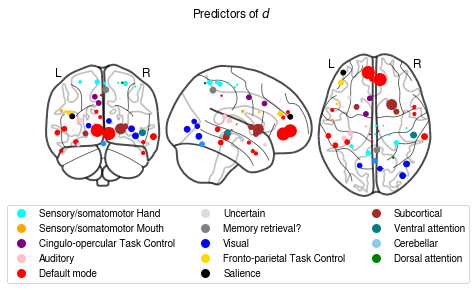

In [17]:
importance = np.sum(np.abs(c), axis=1)
size = np.power(importance, 2)
fig, axs = plt.subplots(2,1, figsize=(7, 4),
                       gridspec_kw={'height_ratios':(10,1)})

d = nip.plot_glass_brain(None, axes=axs[0], display_mode="ortho")
d.add_markers(nc, 
              marker_color=[colortranslate(x) for x in cols], 
              marker_size = 40000*size)
#d.add_contours("episodic_memory_association-test_z_FDR_0.01.nii.gz", levels=[0], filled=True, colors="#FF000033")
#d.add_contours("memory_retrieval_association-test_z_FDR_0.01.nii.gz", levels=[0], filled=True, colors="#0000FF33")
#d.add_contours("autobiographical_memory_association-test_z_FDR_0.01.nii.gz", levels=[0], filled=True, colors="#00FF0033")
axs[1].axis('off')
axs[1].legend(handles, nets, loc="center", ncol=3)
fig.suptitle("Predictors of $d$")
plt.savefig("nsf_sch.png", dpi=300)
#fig.suptitle("Node importance")
#plt.savefig("alpha4_florian.png", dpi=300)

## Comparison to Task-Based Meta-Analytic Activations

Here we compare the distributions of ROIs to existing meta-analytic data from neurosynth 

/home/andrea/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


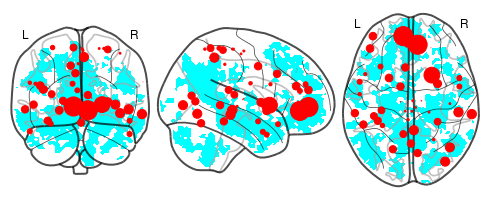

In [18]:
d  = nip.plot_glass_brain(None, display_mode="ortho")
#d.add_contours("memory_retrieval_association-test_z_FDR_0.01.nii.gz", levels=[1], filled=True, colors="aqua")
d.add_contours("autobiographical_memory_association-test_z_FDR_0.01.nii.gz", levels=[1], filled=True, colors="aqua")
d.add_markers(nc, 
              marker_color="red",
              marker_size = 100000* size)


In [ ]:
print(nc)
subset

### Results vs. Meta-Analysis of Memory Retrieval

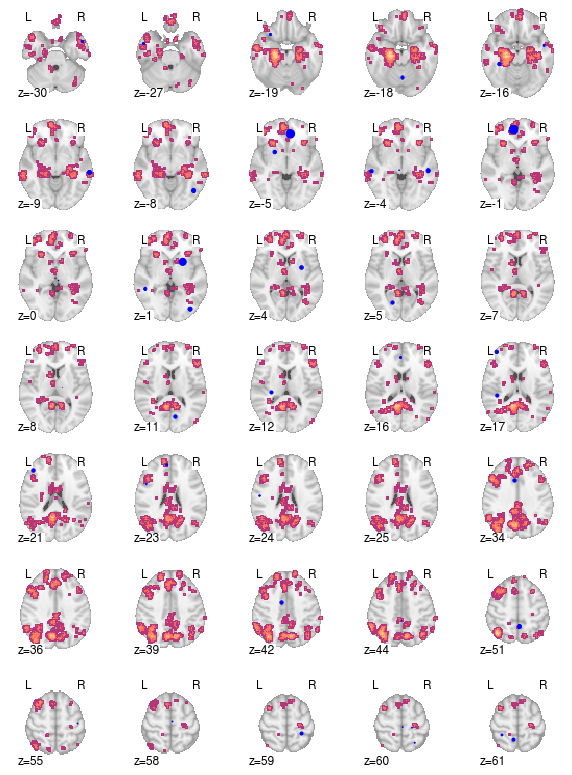

In [19]:
Z = sorted(set(subset["Z"]))
K = list(np.array(subset[["X", "Y", "Z"]]))
K = [list(k) for k in K]
S = ["%s" % k for k in K]
D = dict(zip(S, [20000*x for x in size] ))
fig, axs = plt.subplots(7, 5, figsize=(10, 14))
img = nimg.smooth_img(nimg.load_img("memory_retrieval_association-test_z_FDR_0.01.nii.gz"), 1.5),
i = 0
for r in range(7):
    for c in range(5):
        
        d  = nip.plot_stat_map(img[0], 
                               axes = axs[r,c], 
                               colorbar=False,
                               display_mode="z", 
                               cut_coords=[Z[i]], 
                               threshold=1e-6,
                               cmap = "magma")
        
        mask = nc[:, 2] == Z[i]
        coords = nc[mask, :]
        #print(coords)
        #print(coords)
        sizes = [D["%s" % list(coord)] for coord in coords]
        #print(sizes)
        d.add_markers(coords, 
                      marker_color="blue",
                      marker_size = sizes)
        i += 1
        
plt.savefig("alpha4_vs_metanalysis_retrieval.png", dpi=300)

### Results vs. Meta-Analsis of Episodic Memory

In [ ]:
fig, axs = plt.subplots(7, 5, figsize=(10, 14))
img = nimg.smooth_img(nimg.load_img("episodic_memory_association-test_z_FDR_0.01.nii.gz"), 1.5),
i = 0
for r in range(7):
    for c in range(5):
        
        d  = nip.plot_stat_map(img[0], 
                               axes = axs[r,c], 
                               colorbar=False,
                               display_mode="z", 
                               cut_coords=[Z[i]], 
                               threshold=1e-6,
                               cmap = "magma")
        
        mask = nc[:, 2] == Z[i]
        coords = nc[mask, :]
        d.add_markers(coords, 
                      marker_color="blue",
                      marker_size = 25)
        i += 1
        
plt.savefig("alpha4_vs_metanalysis_episodic.png", dpi=300)

### Results vs. Meta-Analysis of Both Episodic Memory and Memory Retrieval

In [ ]:
fig, axs = plt.subplots(7, 5, figsize=(10, 14))
episodic_img = nimg.smooth_img(nimg.load_img("episodic_memory_association-test_z_FDR_0.01.nii.gz"), 1.5)
retrieval_img = nimg.smooth_img(nimg.load_img("memory_retrieval_association-test_z_FDR_0.01.nii.gz"), 1.5)

result_img = nimg.math_img("img1 + img2",
                           img1=episodic_img, img2=retrieval_img)
i = 0
for r in range(7):
    for c in range(5):
        
        d  = nip.plot_stat_map(result_img, 
                               axes = axs[r,c], 
                               colorbar=False,
                               display_mode="z", 
                               cut_coords=[Z[i]], 
                               threshold=1e-6,
                               cmap = "magma")
        
        mask = nc[:, 2] == Z[i]
        coords = nc[mask, :]
        d.add_markers(coords, 
                      marker_color="blue",
                      marker_size = 25)
        i += 1
        
plt.savefig("alpha4_vs_metanalysis_episodic+retrieval.png", dpi=300)

## Results vs. Meta-Analytic Map of Alzheimer's disease (N=263 studies)


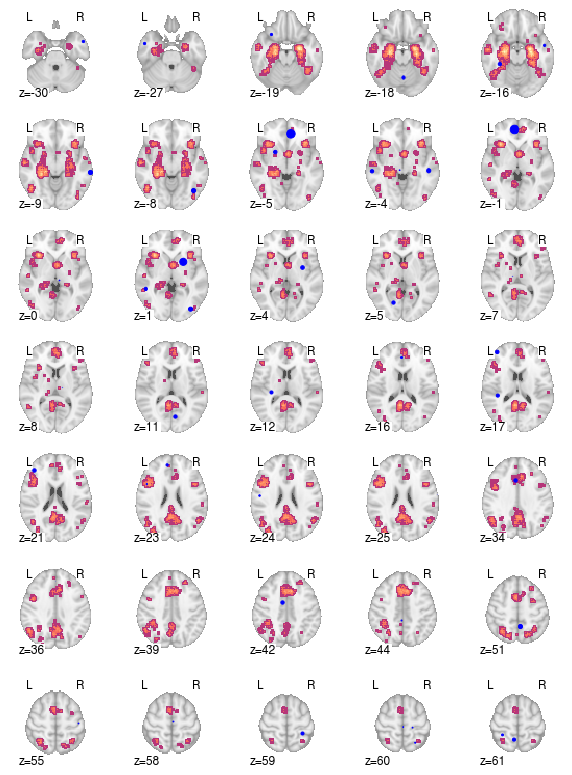

In [22]:
Z = sorted(set(subset["Z"]))
K = list(np.array(subset[["X", "Y", "Z"]]))
K = [list(k) for k in K]
S = ["%s" % k for k in K]
D = dict(zip(S, [20000*x for x in size] ))
fig, axs = plt.subplots(7, 5, figsize=(10, 14))
img = nimg.smooth_img(nimg.load_img("alzheimer disease_uniformity-test_z_FDR_0.01.nii.gz"), 1.5),
i = 0
for r in range(7):
    for c in range(5):
        
        d  = nip.plot_stat_map(img[0], 
                               axes = axs[r,c], 
                               colorbar=False,
                               display_mode="z", 
                               cut_coords=[Z[i]], 
                               threshold=1e-6,
                               cmap = "magma")
        
        mask = nc[:, 2] == Z[i]
        coords = nc[mask, :]
        #print(coords)
        #print(coords)
        sizes = [D["%s" % list(coord)] for coord in coords]
        #print(sizes)
        d.add_markers(coords, 
                      marker_color="blue",
                      marker_size = sizes)
        i += 1
        
plt.savefig("alpha4_vs_metanalysis_alzheimers.png", dpi=300)